## This notebook is a simple implementation of bag-of-words model for filtering spam emails. 

In [1]:
import nltk
import csv

In [2]:
# Train set is a list of tuples in a form of ('str', x) where str is the email
# and x is either 1 if it's a spam message, or 0 if it's not. 
train_set = []
test_set = []

### Opening the dataset from a .csv file

In [3]:
# Opening the dataset
with open('dataset/spam_ham_dataset.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    for i, row in enumerate(reader):
        # The first row is labels
        if i == 0: continue
        # The test set should have 1000 examples
        if len(test_set) < 1000:
            test_set.append((row[2], int(row[3])))
        else:
            train_set.append((row[2], int(row[3])))

In [4]:
len(train_set), len(test_set)

(4171, 1000)

### Training the spam filter
The code below goes through the training data and counts the occurence of every single word in spam emails
and ham emails. Those counts are stored in two dictionaries along the total number of words in each category.

In [5]:
# This is the dictionary in which each word from the spam dataset
# will be stored, and counted.
spam_freq: dict = {}
# The same for normal, not 'spam' emails.
ham_freq: dict = {} 

n_of_spam_words = 0
n_of_ham_words = 0

# Counting the total number of spam and ham emails in the training data.
n_of_spam_emails = 0
n_of_ham_emails = 0

for i in train_set:
    # Tokenizing the email
    tokens = nltk.word_tokenize(i[0])
    # Removing the punctuations and numbers
    temp = []
    for j in tokens:
        if j.isalpha():
            temp.append(j.lower())

    tokens = temp
    
    if i[1]:
        n_of_spam_emails += 1
        for j in tokens:
            if j not in spam_freq:
                spam_freq[j] = 1
            else:
                spam_freq[j] += 1
            n_of_spam_words += 1
    else:
        n_of_ham_emails += 1
        for j in tokens:
            if j not in ham_freq:
                ham_freq[j] = 1
            else:
                ham_freq[j] += 1
            n_of_ham_words += 1


### This function classifies emails either as spam or ham using the Naive Bayes spam filter.
It does so by assuming that the probability of each word occuring in an email is independent, and with this assumption it is justifiable to use this formula:
$$
P(S|x_1,x_2,x_3,\ldots) = \frac{P(S)\prod_{i=1}^{n}P(x_i|S)}{P(S)\prod_{i=1}^{n}P(x_i|S) + P(H)\prod_{i=1}^{n}P(x_i|H)}
$$
where:
- $ P(S|x_1,x_2,x_3,\ldots) $ is the probability that this email is spam given that the words $ x_1,x_2,x_3,\ldots $ occur in it
- $ P(S) $ is the probability that this email is spam (based on the ratio of spam/ham emails in the training data)
- $ P(x_1|S) $ is the probability of word $ x_i $ cccuring in an email given that it is spam. This can be calcuated using the frequency of this word in spam emails.
- $ P(H) $ is the probability that this email is ham.
- $ P(x_i|H) $ is the probability of the word $ x_i $ occuring given that this is a ham email.

The derivation of this formula can be found at https://courses.cs.washington.edu/courses/cse312/18sp/lectures/naive-bayes/naivebayesnotes.pdf

In [6]:
def filter(email, threshould):
    """Returns True if [email] is spam, else False. [threshould] sets the level of accuracy."""

    # Tokenizing the email
    tokens = nltk.word_tokenize(email)
    # Removing the punctuations and numbers
    temp = []
    for j in tokens:
        if j.isalpha():
            temp.append(j.lower())

    tokens = temp

    # Calculating the probabilities
    p_s = n_of_spam_emails/(n_of_spam_emails + n_of_ham_emails)
    p_h = n_of_ham_emails/(n_of_spam_emails + n_of_ham_emails)

    p_s_conditional = 1
    p_h_conditional = 1    

    for t in tokens:
        p_s_conditional *= (spam_freq[t]/n_of_spam_words) if t in spam_freq else 1
        p_h_conditional *= (ham_freq[t]/n_of_ham_words) if t in ham_freq else 1

    # Adding 2.2250738585072014e-308 (the smallest float value) to prevent division by zero error
    p = (p_s * p_s_conditional)/(p_s * p_s_conditional + p_h * p_h_conditional + 2.2250738585072014e-308)

    if p > threshould:
        return True
    else:
        return False

    

### Testing
Applying the filter function to the test data.

In [7]:
score = 0
count = 0
for i in test_set:
    if filter(i[0], 0.95) == i[1]:
        score += 1
    count += 1

print(f"The score is {score}/{count}")

The score is 433/1000


The filter function rarely works correctly, the only reason it scores 433/1000 is that it computes the probability p to be very close to 1 most of the time, and the spam emails are about 28% of the test data.

The reason it works so bad is that most words from the test dataset emails are not in emails from the training dataset and by default it ignores those by simply assuming that their conditional probability is 1.
Another problem with this function is that it has floating-point underflow. The products of conditional probabilities in the formula are very close to 0 (on the level of 1e-80 to 1e-200) and it sometimes happens that they go below the smallest floating point value (which is 2.2250738585072014e-308), resulting in the final probability being equal to 0. 

To solve those issues i will use converted formula for the final probability that can be found at https://en.wikipedia.org/wiki/Naive_Bayes_spam_filtering and i will assume that there are about 20,000 words in everyday english (this number can be adjusted) so the default conditional probability of any word is 1/20,000. 

In [8]:
import math

In [9]:
def filter2(email, threshould):
    """Returns True if [email] is spam, else False. [threshould] sets the level of accuracy."""

    # Tokenizing the email
    tokens = nltk.word_tokenize(email)
    # Removing the punctuations and numbers
    temp = []
    for j in tokens:
        if j.isalpha():
            temp.append(j.lower())

    tokens = temp

    # Calculating the probabilities
    p_s = n_of_spam_emails/(n_of_spam_emails + n_of_ham_emails)
    p_h = n_of_ham_emails/(n_of_spam_emails + n_of_ham_emails)

    eta = math.log(p_h) - math.log(p_s)

    for t in tokens:
        p_s_conditional = spam_freq[t]/n_of_spam_words if t in spam_freq else 1/20000
        p_h_conditional = ham_freq[t]/n_of_ham_words if t in ham_freq else 1/20000
        eta += math.log(p_h_conditional) - math.log(p_s_conditional)

    # Using try and except because math.exp was throwing overflow errors
    try:
        p = 1/(1 + math.exp(eta))
    except:
        p = 0

    if p > threshould:
        return True
    else:
        return False

### Testing
Applying the filter2 function to the test data.

In [10]:
score = 0
count = 0
for i in test_set:
    if filter2(i[0], 0.95) == i[1]:
        score += 1
    count += 1

print(f"The score is {score}/{count}")

The score is 891/1000


filter2 function already beats the last version with the score 891/1000 but there are still improvements to be made.

The next modification of this function will take three parameters, the email, the threshould and the default conditional probability of any word (previously i assumed it to be 1/20000 by default). I will try to find the best hyperparameters by brute force search.

In [11]:
def filter3(email, threshould, default_p):
    """Returns True if [email] is spam, else False. [threshould] sets the level of accuracy."""

    # Tokenizing the email
    tokens = nltk.word_tokenize(email)
    # Removing the punctuations and numbers
    temp = []
    for j in tokens:
        if j.isalpha():
            temp.append(j.lower())

    tokens = temp

    # Calculating the probabilities
    p_s = n_of_spam_emails/(n_of_spam_emails + n_of_ham_emails)
    p_h = n_of_ham_emails/(n_of_spam_emails + n_of_ham_emails)

    eta = math.log(p_h) - math.log(p_s)

    for t in tokens:
        p_s_conditional = spam_freq[t]/n_of_spam_words if t in spam_freq else default_p
        p_h_conditional = ham_freq[t]/n_of_ham_words if t in ham_freq else default_p
        eta += math.log(p_h_conditional) - math.log(p_s_conditional)

    # Using try and except because math.exp was throwing overflow errors
    try:
        p = 1/(1 + math.exp(eta))
    except:
        p = 0

    if p > threshould:
        return True
    else:
        return False

In [12]:
import numpy as np
import matplotlib.pyplot as plt

### Searching for the best hyperparameters

Best threshould: 0.5, best default probability: 1e-05, best score: 954


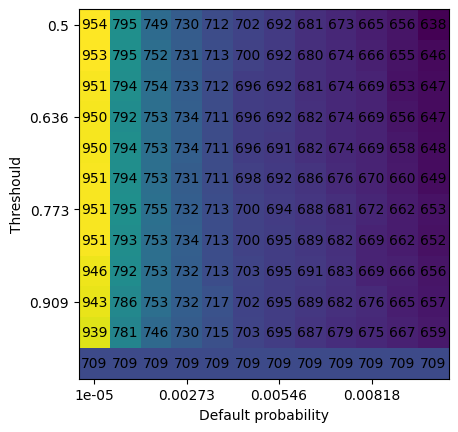

In [17]:
# The number of tries in each dimension
dim = 12

# List of scores for plotting the filter3 function with respect to the hyperparameters
scores = [[0 for _ in range(dim)] for _ in range(dim)]
best_threshould = 0
best_default_p = 0
best_score = 0

# Searching for the best hyperparameters
for i, t in enumerate(np.linspace(0.5, 1, num=dim)):
    for j, p in enumerate(np.linspace(1e-5, 1e-2, num=dim)):
        score = 0
        for e in test_set:
            if filter3(e[0], t, p) == e[1]:
                score += 1
        scores[i][j] = score
        if score > best_score:
            best_score = score
            best_threshould = t
            best_default_p = p

print(f"Best threshould: {best_threshould}, best default probability: {best_default_p}, best score: {best_score}")

# Plotting the function with respect to the hyperparameters
plt.imshow(scores)
# Styling the plot
xs = []
xticks = []
for i, n in enumerate(np.linspace(1e-5, 1e-2, num=dim)):
    if i % 3 != 0:
        continue
    xticks.append(f"{n:.3}")
    xs.append(i)
plt.xticks(xs, xticks)
ys = []
yticks = []
for i,n in enumerate(np.linspace(0.5, 1, num=dim)):
    if i % 3 != 0:
        continue
    yticks.append(f"{n:.3}")
    ys.append(i)
plt.yticks(ys, yticks)
for i in range(dim):
    for j in range(dim):
        plt.text(j,i, f"{scores[i][j]}", ha='center', va='center')
plt.xlabel("Default probability")
plt.ylabel("Threshould")
plt.show()

It turns out that just by changing the hyperparameters it is possible to achieve 954/1000 accuracy.